# Tutorial: How to use ExTrack


In [2]:
import extrack
import numpy as np
from matplotlib import pyplot as plt
import os

version: 1.5.1


# Simulating tracks

In order to simulate tracks able to come and leave from the field of view, One can use the following function:

### Function extrack.simulate_tracks.sim_FOV

#### Arguments:

- `nb_tracks`: Number of tracks simulated.
- `max_track_len`: Number of steps simulated per track. Defines a maximum track length.
- `min_track_len`: Minimal track length for the track to be considered.
- `LocErr`: 1D array of average localization error (std of the distance between particle and center of detected peak) for each dimension.
- `Ds`: 1D array of the diffusion coefs for each state.
- `TrMat`: Transition array per step (lines: state at time n, cols: states at time n+1).
- `dt`: Time in between frames.
- `nb_dims`: Number of dimensions to output, simulations are always performed in 3D but only the nb_dims first spatial dimensions are kept.
- `LocErr_std`: Standard deviation of the distribution of localization errors
- `pBL`: Probability of bleaching (or not detecting the peak) per step.
- `cell_dims`: Dimension limits in x, y and z respectively. x, y dimension limits are useful when tracking membrane proteins in tirf when the particles leave the field of view from the sides of the cells. z dimension is relevant for cytoplasmic proteins which can leave from the z axis. It considers the particles can leave from both ends of each axis: multiply axis limit by 2 to aproximate tracks leaving from one end only.

#### Outputs:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `all_Bs`: Dictionary descibing the true states of tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `all_sigmas`: Dictionary describing the localization errors of each peak with the same format as the other outputs, track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = spatial dimensions.

In [3]:
dt = 0.02

# extrack.simulate_tracks.sim_FOV allows to simulate tracks able to leave the field of view

all_tracks, all_Bs, all_sigmas = extrack.simulate_tracks.sim_FOV(nb_tracks=5000,#increase this number to simulate more tracks and gain in precision
                                                     max_track_len=60,
                                                     min_track_len = 21,
                                                     LocErr=np.array([0.02, 0.02, 0.04]), # localization error in x, y and z (even if not used)
                                                     Ds = np.array([0,0.25]),
                                                     initial_fractions = np.array([0.6,0.4]),
                                                     TrMat = np.array([[0.9,0.1],[0.1,0.9]]),
                                                     dt = dt,
                                                     nb_dims = 2,
                                                     LocErr_std = 0, # normalized standard deviation of localization error (coef of variation)
                                                     pBL = 0.05,
                                                     cell_dims = [1,None,None])

number of tracks:
21 pos : 99, 22 pos : 97, 23 pos : 92, 24 pos : 112, 25 pos : 95, 26 pos : 75, 27 pos : 66, 28 pos : 57, 29 pos : 72, 30 pos : 56, 31 pos : 64, 32 pos : 48, 33 pos : 39, 34 pos : 45, 35 pos : 45, 36 pos : 36, 37 pos : 34, 38 pos : 26, 39 pos : 29, 40 pos : 31, 41 pos : 22, 42 pos : 22, 43 pos : 22, 44 pos : 27, 45 pos : 17, 46 pos : 12, 47 pos : 16, 48 pos : 11, 49 pos : 12, 50 pos : 16, 51 pos : 12, 52 pos : 11, 53 pos : 18, 54 pos : 8, 55 pos : 8, 56 pos : 8, 57 pos : 10, 58 pos : 14, 59 pos : 5, 60 pos : 69, 


# Loading data sets


## Load csv files (or other tables)

### function extrack.readers.read_table

The function `extrack.readers.read_table` can be used if files are saved as pickle, csv or other table format with column headers and where each line represents a peak, and each column a property of peaks (at least the x and y positions, the frame number and the track ID). See format:

<img src="http://localhost:8888/notebooks/Downloads/img1.png">

#### Arguments:

- `path`: Path to the data in the trackmate xml format.
- `lengths`: track lengths considered (default value = `np.arange(5,16)`).
- `dist_th`: Maximal distance between consecutive time points (default value = `0.3`).
- `frames_boundaries`: first frame and last frame to consider (default value = `[-np.inf,np.inf]`).
- `fmt`: Format of the document to be red, can be `'csv'` or `'pkl'`. One can also simply specify a separator in case of another table format, e.g. `';'` if colums are separated by ;.
- `colnames`: List of the header names used in the table file to load corresponding to the coordianates, the frame and track ID for each peak. The first elements must be the coordinates headers (1 to 3 for 1D to 3D), the penultimate must be the frame header and the last element must be the track ID of the peak (default value = `['POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID']`).
- `opt_colnames`: List of additional metrics to collect from the file, e.g. `['QUALITY', 'ID']`,(default value = `[]`).
- `remove_no_disp`: If True, removes tracks that show absolutly no displacements as most likely arising from wrong peak detection.

#### Outputs:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `all_frames`: Dictionary descibing the frame numbers of each peak of all tracks with track length as keys (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position.
- `optional_metrics`: Dictionary describing the optional metrics specified by opt_colnames for each peak of all tracks with the same format as the other outputs, track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = optional metrics (same length as the length of the list `opt_colnames`).


In [3]:
path = './example_tracks.csv'

# In order to import a file from a csv format, the user must specify the necessary column headers of the csv.
# the argument colnames is a list containing the names of the spacial dimension (the 2 first elements for 2D and 3 first elements for 3D)
# the last 2 elements of colnames must contain header of column for: - the frame of each peak (must be integer of float) 
#                                                                    - and the Track ID.

tracks, frames, opt_metrics = extrack.readers.read_table(path, # path of the file to read or list of paths
                                      lengths = np.arange(5,16), # number of positions per track accepted (take the first position if longer than max
                                      dist_th = 0.3, # maximum distance allowed for consecutive positions 
                                      frames_boundaries = [0, 10000], # minimum and maximum frames to consider
                                      fmt = 'csv', # format of the document to be red, 'csv' or 'pkl', one can also just specify a separator e.g. ' '. 
                                      colnames = ['POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID'], 
                                      opt_colnames = ['QUALITY'], # list of additional metrics to collect e.g. ['QUALITY', 'TRACK_ID']
                                      remove_no_disp = True)



## Load TrackMate xml files

One can also load tracks from actual experiments. If files are saved from trackmate using the trackmate xml output format, load tracks with the function `extrack.readers.read_trackmate_xml`. See format:

<img src="http://localhost:8888/notebooks/Downloads/img2.png">

### Function extrack.readers.read_trackmate_xml

#### Arguments:

- `path`: Path to the data in the trackmate xml format.
- `lengths`: Track lengths considered (default value = `np.arange(5,16)`).
- `dist_th`: Maximal distance between consecutive time points (default value = `0.3`).
- `start_frame`: First frame to consider (default value = `0`).
- `remove_no_disp`: If True, removes tracks that show absolutly no displacements as most likely arising from wrong peak detection.
- `opt_metrics_names`: Optional values to keep track of (default value = `[]`, can be `['pred_0', 'pred_1']` for instance),
- `opt_metrics_types`: Type of the optional values (default value = `None`, will assume `'float64'` type if `None`).

#### Outputs:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `all_frames`: Dictionary descibing the frame numbers of each peak of all tracks with track length as keys (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position.
- `optional_metrics`: Dictionary describing the optional metrics specified by `opt_metrics_names` for each peak of all tracks with the same format as the other outputs, track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = optional metrics (same length as the length of the list `opt_metrics_names`).


In [11]:
path = './example_tracks.xml'

tracks, frames, opt_metrics = extrack.readers.read_trackmate_xml(path,
                                       lengths=np.arange(5,16),
                                       dist_th = 0.3,
                                       frames_boundaries = [0, 10000],
                                       remove_no_disp = True, 
                                       opt_metrics_names = [], # Name of the optional metrics to catch and returned by opt_metrics, opt_metrics will be empty if opt_metrics_names list is empty
                                       opt_metrics_types = None # will assume 'float64' type if none, otherwise specify a list of same length as opt_metrics_names: e.g. ['float64','float64']
                                       )
print(opt_metrics) # should be empty if opt_metrics_names is empty

{}


# Parameter fitting

In order to do the fit we first need to instantiate the parameters of the fit, To do so there is 2 methods:

The first method consist in creating 4 dictionaries `vary_params`, `estimated_vals`, `min_values`, `max_values` with parameters of the fit as keys and various elements.

#### Arguments:

- `vary_params`: Elements True if the parameter must vary, False otherwise.
- `estimated_vals`: Estimated value used to initialize the fit. Good estimation increases speed and decreases chances of wrong local minima.
- `min_values`: Minimum values for each parameter.
- `max_values`: Maximum values for each parameter.

The second, quicker, is to use the function generate_params. See  for more details on this function and to see how to perform other types of fit (independent localization error for each spatial dimensions, input localization errors for each peak, etc)


In [5]:
# In order to do the fit we first need to instanciate parameters:

vary_params = {'LocErr' : True, 'D0' : True, 'D1' : True, 'F0' : True, 'p01' : True, 'p10' : True, 'pBL' : False}
estimated_vals =  {'LocErr' : 0.025, 'D0' : 1e-20, 'D1' : 0.05, 'F0' : 0.45, 'p01' : 0.05, 'p10' : 0.05, 'pBL' : 0.1}
min_values = {'LocErr' : 0.007, 'D0' : 1e-12, 'D1' : 0.00001, 'F0' : 0.001, 'p01' : 0.001, 'p10' : 0.001, 'pBL' : 0.001}
max_values = {'LocErr' : 0.6, 'D0' : 1, 'D1' : 10, 'F0' : 0.999, 'p01' : 1., 'p10' : 1., 'pBL' : 0.99}

params = extrack.tracking.get_params(nb_states = 2,
                    steady_state = False,
                    vary_params = vary_params,
                    estimated_vals = estimated_vals,
                    min_values = min_values,
                    max_values = max_values)

# The following function allows the fitting of parameters from ExTrack to the data set:

model_fit = extrack.tracking.param_fitting(all_tracks = all_tracks,
                                          dt = dt,
                                          params = params,
                                          nb_states = 2,
                                          nb_substeps = 1,
                                          cell_dims = [1],
                                          frame_len = 4,
                                          verbose = 0,
                                          workers = 1, # increase the number of CPU workers for faster computing, do not work on windows or mac (keep to 1)
                                          input_LocErr = None,
                                          steady_state = False,
                                          )

params = model_fit.params
for param in params:
    print(param, params[param].value)

..............................................................................................................................................................................................................................................................................................................................
LocErr 0.020088914413544736
D0 9.550326618502171e-07
D1_minus_D0 0.24417166863671125
D1 0.2441726236693731
F0 0.5117302449999714
F1 0.48826975500002856
p01 0.08945619589337873
p10 0.11206253149600819
pBL 0.1


The following function allows the fitting of parameters from ExTrack to the data set:

### Funtion extrack.tracking.param_fitting

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position. This means 15 tracks of 7 time points in 2D will correspond to an array of shape `[15,7,2]`. 
- `dt`: Time in between frames.
- `params`: Parameters previously instanciated.
- `nb_states`: Number of states. `vary_params`, `estimated_vals`, `min_values`, `max_values` should be changed accordingly to describe all states and transitions.
- `nb_substeps`: Number of considered transition steps in between consecutive 2 positions.
- `frame_len`: Number of frames for which the probability is perfectly computed. See method of the paper for more details.
- `verbose`: If 1, print the intermediate values for each iteration of the fit.
- `steady_state`: True if tracks are considered at steady state (fractions independent of time), this is most likely not true as tracks join and leave the FOV.
- `workers`: Number of workers used for the fitting, allows to speed up computation. Do not work from windows at the moment.
- `cell_dims`: Dimension limits (um) (default `[1]`, can also be `[1,2]` for instance).

#### Outputs:

- model_fit: lmfit model

# State duration histograms

Next, once we have estimated the parameters of the model, we can produce histograms of time spent in each state using the following function:

### Function extrack.visualization.visualize_states_durations

#### arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position. This means 15 tracks of 7 time points in 2D will correspond to an array of shape `[15,7,2]`. 
- `params`: lmfit parameters used for the model. can be extracted from the model using model_fit.params.
- `dt`: Time in between frames.
- `cell_dims`: Dimension limits (um).
- `max_nb_states`: Maximum number of sequences kept (most likely sequences).
- `nb_steps_lim`: Upper limit of the plot in the x axis (number of steps).
- `long_tracks`: If True only selects tracks longer than `nb_steps_lim`.
- `steps`: x axis in seconds if False or in number of steps if False.

#### outputs:

- Plot of all tracks (preferencially input a single movie)

number of chunks: 55

slop for state 0: -0.10158688001379303
slop for state 1: -0.148941578874581


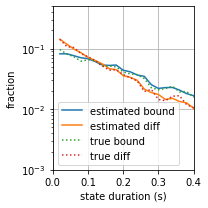

In [6]:
extrack.visualization.visualize_states_durations(all_tracks,
                                                 params = params,
                                                 dt = dt,
                                                 cell_dims = [1],
                                                 nb_states = 2,
                                                 max_nb_states = 200,
                                                 long_tracks = True,
                                                 nb_steps_lim = 20,
                                                 steps = False)

# ground truth histogram (actual labeling from simulations which cannot be assessed for real tracks):

seg_len_hists = extrack.histograms.ground_truth_hist(all_Bs, 2)
plt.plot(np.arange(1,len(seg_len_hists)+1)[:,None]*dt, seg_len_hists/np.sum(seg_len_hists,0), ':')
plt.legend(['estimated bound','estimated diff','true bound','true diff'])

# computation of the slops of the histograms:

print('slop for state 0:', np.polyfit(np.arange(1,len(seg_len_hists))[3:15], np.log(seg_len_hists[3:15])[:,0], 1)[0])
print('slop for state 1:', np.polyfit(np.arange(1,len(seg_len_hists))[3:15], np.log(seg_len_hists[3:15])[:,1], 1)[0])

# we can notice the slops are not equal to the rates due to the fraction of tracks leaving the field of view.

We saw the function extrack.tracking.get_params to produce parameters. One can also use the function `extrack.tracking.generate_params`.

See https://github.com/vanTeeffelenLab/ExTrack/wiki/Parameters-for-fitting for more details on this function. 

In [5]:
# Here we use this function to set param values.

params = extrack.tracking.generate_params(nb_states = 2,
                        LocErr_type = 1,
                        nb_dims = 2, # only matters if LocErr_type == 2.
                        LocErr_bounds = [0.005, 0.1], # the initial guess on LocErr will be the geometric mean of the boundaries.
                        D_max = 10, # maximal diffusion coefficient allowed.
                        Fractions_bounds = [0.001, 0.99],
                        estimated_LocErr = [0.02],
                        estimated_Ds = [0, 0.25], # D will be arbitrary spaced from 0 to D_max if None, otherwise input a list of Ds for each state from state 0 to nb_states - 1.
                        estimated_Fs = [0.5,0.5], # fractions will be equal if None, otherwise input a list of fractions for each state from state 0 to nb_states - 1.
                        estimated_transition_rates = [0.1, 0.1], # transition rate per step. example [0.1,0.05,0.03,0.07,0.2,0.2] for a 3-state model.
                        )

# can be addapted for more states by specifying all the relevant parameters.

# parameters can be fixed using the following command (here for 'D0' but also works with any parameter):
params['D0'].vary = False

# Probabilistic state annotation

ExTrack can also perform state preditions using the following function:

## Performing state predictions

### Function extrack.tracking.predict_Bs

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position. This means 15 tracks of 7 time points in 2D will correspond to an array of shape `[15,7,2]`.
- `params`: lmfit parameters used for the model.
- `dt`: Time in between frames.
- `cell_dims`: Dimension limits (um).
- `nb_states`: Number of states.`vary_params`, `estimated_vals`, `min_values`, `max_values` should be changed accordingly to describe all states and transitions.
- `frame_len`: Number of frames for which the probability is accurately computed. See method of the paper for more details.

#### Outputs:

- `pred_Bs`: Dictionary describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.

In [6]:

# simulation of fiewer tracks to plot them and their annotation infered by ExTrack :

all_tracks, all_Bs, all_sigmas = extrack.simulate_tracks.sim_FOV(nb_tracks=300,
                                                     max_track_len=60,
                                                     min_track_len = 5,
                                                     LocErr=0.02,
                                                     Ds = np.array([0,0.5]),
                                                     initial_fractions = np.array([0.6,0.4]),
                                                     TrMat = np.array([[0.9,0.1],[0.1,0.9]]),
                                                     dt = dt,
                                                     pBL = 0.1,
                                                     LocErr_std = 0.1, # normalized standard deviation of localization error (coef of variation)
                                                     cell_dims = [1,] # dimension limits in x, y and z respectively
                                                     )

# performs the states probability predictions based on the most likely parameters :

pred_Bs = extrack.tracking.predict_Bs(all_tracks,
                                      dt = dt,
                                      params = params,
                                      cell_dims=[1],
                                      nb_states=2,
                                      frame_len=8,
                                      workers = 1,
                                      input_LocErr = all_sigmas)



number of tracks:
5 pos : 34, 6 pos : 29, 7 pos : 25, 8 pos : 25, 9 pos : 22, 10 pos : 16, 11 pos : 10, 12 pos : 18, 13 pos : 14, 14 pos : 5, 15 pos : 5, 16 pos : 4, 17 pos : 2, 18 pos : 4, 19 pos : 7, 20 pos : 2, 21 pos : 5, 22 pos : 4, 23 pos : 2, 24 pos : 3, 26 pos : 3, 28 pos : 2, 30 pos : 1, 31 pos : 1, 32 pos : 2, 33 pos : 1, 36 pos : 1, 39 pos : 1, 40 pos : 2, 42 pos : 1, 46 pos : 1, 


## Converting ExTrack format to pandas dataframe

Turn outputs from extrack to a more classical data frame format:

### Function extrack.exporters.extrack_2_pandas

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `pred_Bs`: Dictionary describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.
- `frames`: Dictionary describing the frame of each position of each track with keys track length (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position, assumed to go from 0 to number of time positions - 1 if none.
- `opt_metrics`: Dictionary of dictionaries for each specified optional metric to add to the dataframe. each array must be a 2D array of dims 0 = tracks, dim 1 = time position. e.g. `{'QUALITY': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...])}, 'SNR': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...]) }}`.

#### Outputs:

- `DATA`: pandas dataframe containing the necessary informations for each track.

In [7]:

DATA = extrack.exporters.extrack_2_pandas(all_tracks, pred_Bs, frames = None, opt_metrics = {})


Then tracks can be save to a xml file with TrackMate format for compatibility with TrackMate or as a CSV file:

## Saving tracks with predictions to TrackMate xml format

To do so one can use the following function:

### Function extrack.exporters.save_extrack_2_xml

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `pred_Bs`: Dictionary describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.
- `params`: lmfit parameters.
- `path`: Path + name of the saved file.
- `dt`: Time in between frames.
- `all_frames`: Dictionary describing the frame of each position of each track with keys track length (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position, assumed to go from 0 to number of time positions - 1 if none.
- `opt_metrics`: Dictionary of dictionaries for each specified optional metric to add to the dataframe. each array must be a 2D array of dims 0 = tracks, dim 1 = time position. e.g. `{'QUALITY': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...])}, 'SNR': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...]) }}`.

In [8]:
# save as xml file used for trackmate :

save_path = './saved_tracks.xml' 
extrack.exporters.save_extrack_2_xml(all_tracks,
                                     pred_Bs,
                                     params = params,
                                     path = save_path,
                                     dt = dt,
                                     all_frames = None,
                                     opt_metrics = {})

# Here we don't have optional metrics to save but see below for an example with optional metrics.


## Saving tracks with predictions to csv format
To do so, Once we have converted variables at the ExTrack format, we can simply use the method to_csv from pandas dataframes:


In [9]:
# save as csv file:
save_path = './saved_tracks.csv' 
DATA.to_csv(save_path)

## Visualizing state perdictions

In order to show all tracks on top of each other, one can use the following function:

### Function extrack.visualization.visualize_tracks

#### Arguments:

- `DATA`: dataframe outputed by extrack.exporters.extrack_2_pandas.
- `track_length_range`: Range of tracks ploted. plotting too many tracks may make it crash.
- `figsize`: Size of the figure plotted.

.............

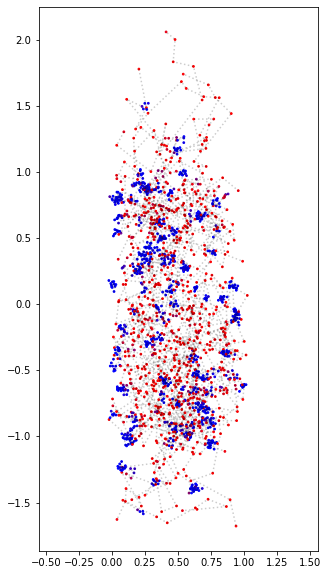

In [10]:
# show all tracks:

extrack.visualization.visualize_tracks(DATA,
                                       track_length_range = [10,np.inf],
                                       figsize = (5,10))

In order to see the longest tracks in more details, one can use the following function:

### Function extrack.visualization.plot_tracks

#### Arguments:

- `DATA`: dataframe outputed by extrack.exporters.extrack_2_pandas.
- `max_track_length`: maximum track length to show, it will plot the longest tracks respecting this criteria.
- `nb_subplots`: number of lines and columns of subplots.
- `figsize`: size of the figure plotted.

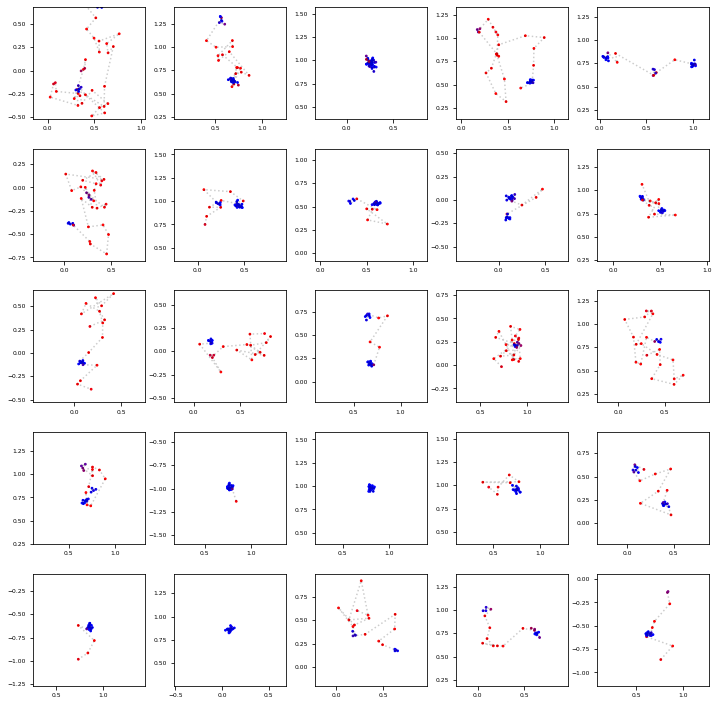

In [14]:
# show the longest tracks in more details :

extrack.visualization.plot_tracks(DATA,
                                  max_track_length = 50,
                                  nb_subplots = [5,5],
                                  figsize = (10,10), 
                                  lim = 0.6)

# Position refinement module

Position refinement module allows to refine track position by integration of the signal over consecutive positions.

## Refined Position and standard deviation

We can noticeably obtain the most likely position for each time point of each track using the function position_refinement:

### Function extrack.refined_localization.position_refinement

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `LocErr`: float number for localization error.
- `ds`: 1D array containing diffusion lengths for each state.
- `Fs`: 1D array containing diffusion lengths for each state.
- `TrMat`: 2D array transition rates. with `TrMat[i,j]` = transition probability from state i to j and `TrMat[i,i] = 1 - sum TrMat[i,j]` for all j.
- `frame_len`: window length to be used from each side of the position to be refined.

#### Outputs:

- `all_mus`: Dictionary describing most likely position with length as keys (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position.
- `all_refined_sigmas`: Dictionary describing refined localization error with length as keys (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position.

NB: This function is not considering specified localization error but will do soon.

number of tracks:
50 pos : 44, 


C:\Users\Franc\anaconda3\lib\site-packages\extrack\refined_localization.py:290: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  best_sigs.append(sigs[[cp.arange(len(mus)), best_args]])
C:\Users\Franc\anaconda3\lib\site-packages\extrack\refined_localization.py:291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  best_mus.append(mus[[cp.arange(len(mus)), best_args]])


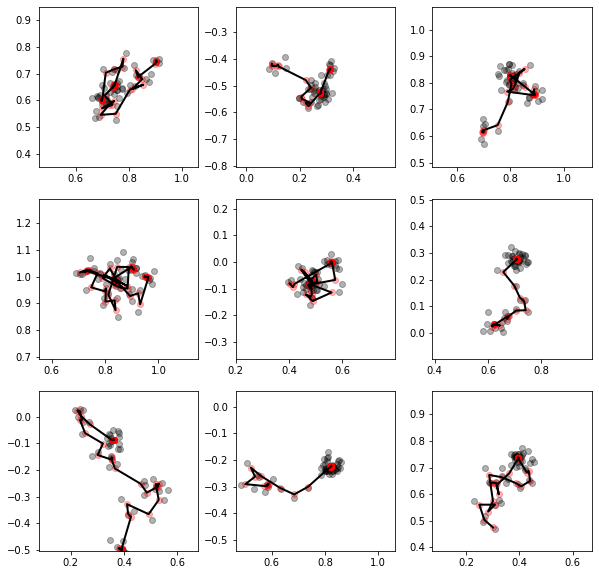

In [2]:

Ds = np.array([0,0.04])
TrMat = np.array([[0.9,0.1],[0.1,0.9]])
Fs = np.array([0.6,0.4])
LocErr = 0.02
dt = 0.02
ds = (2*Ds*dt)**0.5 # d* of 3
track_len = 50

all_tracks, all_Bs, all_sigmas = extrack.simulate_tracks.sim_FOV(nb_tracks=60,
                                                     max_track_len=track_len,
                                                     min_track_len = track_len,
                                                     LocErr=LocErr,
                                                     Ds = Ds,
                                                     initial_fractions = Fs,
                                                     TrMat = TrMat,
                                                     dt = dt,
                                                     pBL = 0.001,
                                                     cell_dims = [1,]) # dimension limits in x, y and z respectively.

all_mus, all_refined_sigmas = extrack.refined_localization.position_refinement(all_tracks, LocErr, ds, Fs, TrMat, frame_len = 7)

plt.figure(figsize = (10,10))

lim = 0.3
for k in range(1, 10):
    plt.subplot(3,3,k)
    track = all_tracks[str(track_len)][k]
    refined_pos = all_mus[str(track_len)][k]
    plt.scatter(track[:,0], track[:,1], c = 'k', alpha = 0.3)
    plt.plot(refined_pos[:,0], refined_pos[:,1], 'k', linewidth = 2)
    plt.scatter(refined_pos[:,0], refined_pos[:,1], c = 'r', alpha = 0.3)
    plt.xlim([np.mean(track[:,0]) - lim, np.mean(track[:,0]) + lim])
    plt.ylim([np.mean(track[:,1]) - lim, np.mean(track[:,1]) + lim])
    plt.gca().set_aspect('equal', adjustable='box')

# The gray dots represent the track positions (with noise) and the red dots represent the most likely positions: 

# Overview of a full pipeline

Now we have seen how each module is working we will run a complete analysis pipeline and save all results in a xml or csv file. This pipeline is realised for tracks which possess peak-wise localization error estimates from the peak detection step. If you want to addapt this pipline to your own data sets and if you don't have peak-wise localization error estimates, have a look at the very last cell of this tutorial. For more insights into the different model assumptions allowed by ExTrack see the other tutorial https://github.com/vanTeeffelenLab/ExTrack/blob/main/Tutorials/Fitting_methods.ipynb or the corresponding wiki page https://github.com/vanTeeffelenLab/ExTrack/wiki/Instanciating-model-parameters.

## Loading tracks

In [18]:
# here data have localization error informations for x and y dimensions LocErrs0 and LocErrs1 (resp.):

dt = 0.02

path =  './tracks.xml' # for xml format

all_tracks, all_frames, opt_metrics = extrack.readers.read_trackmate_xml(path,
                                       lengths=np.arange(5,50),
                                       dist_th = 1,
                                       frames_boundaries = [0, 10000],
                                       remove_no_disp = True, 
                                       opt_metrics_names = ['LocErrs0', 'LocErrs1'], # e.g. ['pred_0', 'pred_1'],
                                       opt_metrics_types = None # will assume 'float64' type if none, otherwise specify a list of same length as opt_metrics_names: e.g. ['float64','float64']
                                       )

# or for a csv file:

path = './tracks.csv'
# headers of the csv above are: X,Y,frame,track_ID,pred_0,pred_1,LocErrs0,LocErrs1.
# We then need to change the argument colnames accordingly.

all_tracks, frames, opt_metrics = extrack.readers.read_table(path, # path of the file to read or list of paths.
                                      lengths = np.arange(5,50), # number of positions per track accepted (take the first position if longer than max.
                                      dist_th = 0.3, # maximum distance allowed for consecutive positions. 
                                      frames_boundaries = [0, 10000], # minimum and maximum frames allowed.
                                      fmt = 'csv', # format of the document to be red, 'csv' or 'pkl', one can also just specify a separator e.g. ' '. 
                                      colnames = ['X', 'Y', 'frame', 'track_ID'], 
                                      opt_colnames = ['LocErrs0', 'LocErrs1'], # list of additional metrics to collect e.g. ['QUALITY', 'TRACK_ID'].
                                      remove_no_disp = True)

print('LocErrs0 shape for tracks of 10 time points is:', opt_metrics['LocErrs0']['10'].shape, 'We need input_LocErr with format (66, 10, 2)')

# We have to turn LocErrs0 and LocErrs1 to the correct shape for input_LocErr, which is (nb tracks, nb time points, nb dims=2).

input_LocErr = {}
for l in all_tracks.keys():
    input_LocErr[l] = np.concatenate((opt_metrics['LocErrs0'][l][:,:,None], opt_metrics['LocErrs1'][l][:,:,None]),axis = 2) # concatenate on the axis 2 which represents the spatial dims


LocErrs0 shape for tracks of 10 time points is: (66, 10) We need input_LocErr with format (66, 10, 2)


## Fitting

In [19]:

params = extrack.tracking.generate_params(nb_states = 2,
                        LocErr_type = None,
                        nb_dims = 2, # only matters if LocErr_type == 2,
                        LocErr_bounds = [0.005, 0.1], # the initial guess on LocErr will be the geometric mean of the boundaries
                        D_max = 10, # maximal diffusion coefficient allowed
                        Fractions_bounds = [0.001, 0.99]
                        )

model_fit = extrack.tracking.param_fitting(all_tracks = all_tracks,
                                          dt = dt,
                                          params = params,
                                          nb_states = 2,
                                          nb_substeps = 1,
                                          cell_dims = [1],
                                          frame_len = 4,
                                          verbose = 0,
                                          workers = 1, # increase the number of CPU workers for faster computing, do not work on windows or mac (keep to 1).
                                          steady_state = False,
                                          input_LocErr = input_LocErr
                                          )

params = model_fit.params
for param in params:
    print(param, params[param].value)

...x...........................................................................x...........xx.x.

C:\Users\Franc\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in multiply
  tmp2 = (x - v) * (fx - fw)


........................................................................xx.x.......................................................................
D0 1.9108673506851304e-05
D1 0.4685778680605873
F0 0.44970260816453184
F1 0.5502973918354681
p01 0.10224719995704806
p10 0.0988752378099102
pBL 0.0988052802020166


## Probabilistic state annotation

In [20]:

pred_Bs = extrack.tracking.predict_Bs(all_tracks,
                                      dt = dt,
                                      params = params,
                                      cell_dims=[1],
                                      nb_states=2,
                                      frame_len=8,
                                      workers = 1,
                                      input_LocErr = input_LocErr)


## Position refinement

In [21]:
Ds = np.array([0,0.05])
TrMat = np.array([[0.9,0.1],[0.1,0.9]])
Fs = np.array([0.6,0.4])
LocErr = 0.02
ds = (2*Ds*dt)**0.5 # d* of 3.
track_len = 50

all_mus, all_refined_sigmas = extrack.refined_localization.position_refinement(all_tracks, LocErr, ds, Fs, TrMat, frame_len = 7)

refined_pos0 = {}
refined_pos1 = {}
refined_LocErrs = {}
for l in all_tracks.keys():
    refined_pos0[l] = all_mus[l][:,:,0]
    refined_pos1[l] = all_mus[l][:,:,1]
    refined_LocErrs[l] = all_refined_sigmas[l][:,:,0]


C:\Users\Franc\anaconda3\lib\site-packages\extrack\refined_localization.py:290: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  best_sigs.append(sigs[[cp.arange(len(mus)), best_args]])
C:\Users\Franc\anaconda3\lib\site-packages\extrack\refined_localization.py:291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  best_mus.append(mus[[cp.arange(len(mus)), best_args]])


## saving as TrackMate xml file 

In [22]:

save_path = './saved_tracks2.xml'

extrack.exporters.save_extrack_2_xml(all_tracks,
                                     pred_Bs,
                                     params = params,
                                     path = save_path,
                                     dt = dt,
                                     all_frames = None,
                                     opt_metrics = {'LocErrs0': opt_metrics['LocErrs0'],
                                                    'LocErrs1': opt_metrics['LocErrs1'], 
                                                    'refined_x_pos': refined_pos0,
                                                    'refined_y_pos': refined_pos1,
                                                    'refined_LocErrs': refined_LocErrs}
                                     )


## saving as csv file 

In [23]:

# first we convert our data to a pandas dataframe:
DATA = extrack.exporters.extrack_2_pandas(all_tracks,
                                          pred_Bs,
                                          frames = None,
                                          opt_metrics = {'LocErrs0': opt_metrics['LocErrs0'],
                                                         'LocErrs1': opt_metrics['LocErrs1'], 
                                                         'refined_x_pos': refined_pos0,
                                                         'refined_y_pos': refined_pos1,
                                                         'refined_LocErrs': refined_LocErrs}
                                          )
print(DATA)

save_path = './saved_tracks2.csv'

DATA.to_csv(save_path)


             X         Y  frame  track_ID    pred_0    pred_1  LocErrs0  \
0     0.234391 -0.089205      0         0  0.884190  0.115810  0.021328   
1     0.187617 -0.070469      1         0  0.986484  0.013516  0.021759   
2     0.233839 -0.056534      2         0  0.986921  0.013079  0.020291   
3     0.156714 -0.055737      3         0  0.954204  0.045796  0.022241   
4     0.185732 -0.027498      4         0  0.902558  0.097442  0.018353   
...        ...       ...    ...       ...       ...       ...       ...   
9805  0.440053 -1.153825     44       890  0.999917  0.000083  0.022228   
9806  0.431732 -1.142476     45       890  0.999907  0.000093  0.022538   
9807  0.450574 -1.144497     46       890  0.999828  0.000172  0.018374   
9808  0.429974 -1.110610     47       890  0.998839  0.001161  0.016955   
9809  0.430944 -1.141991     48       890  0.994550  0.005450  0.016759   

      LocErrs1  refined_x_pos  refined_y_pos  refined_LocErrs  
0     0.019993       0.228324      

# Full pipeline considering localization error as a fitted parameter.

Here, contrary to the full pipeline presented above, we don't have prior knowledge on localization error based on peaks so we assum a unique localization error that can be fitted by specifying `LocErr_type = 1` in the function `extrack.tracking.generate_params`. For different model assumptions see the other tutorial https://github.com/vanTeeffelenLab/ExTrack/blob/main/Tutorials/Fitting_methods.ipynb/Fitting_methods.ipynb.

...x...........................................................................................x..........xx.x

C:\Users\Franc\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in multiply
  tmp2 = (x - v) * (fx - fw)


...........................................................................................................................................................................
D0 2.7289995479518048e-05
D1 0.46896854133837207
LocErr 0.020118651676096094
F0 0.44830032786276247
F1 0.5516996721372376
p01 0.10151640762508399
p10 0.09872327030252447
pBL 0.09872984413836908


C:\Users\Franc\anaconda3\lib\site-packages\extrack\refined_localization.py:290: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  best_sigs.append(sigs[[cp.arange(len(mus)), best_args]])
C:\Users\Franc\anaconda3\lib\site-packages\extrack\refined_localization.py:291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  best_mus.append(mus[[cp.arange(len(mus)), best_args]])


             X         Y  frame  track_ID    pred_0    pred_1  refined_x_pos  \
0     0.234391 -0.089205      0         0  0.879314  0.120686       0.199838   
1     0.187617 -0.070469      1         0  0.984074  0.015926       0.199745   
2     0.233839 -0.056534      2         0  0.982577  0.017423       0.199684   
3     0.156714 -0.055737      3         0  0.937778  0.062222       0.199532   
4     0.185732 -0.027498      4         0  0.896149  0.103851       0.199495   
...        ...       ...    ...       ...       ...       ...            ...   
9805  0.440053 -1.153825     44       890  0.999944  0.000056       0.435848   
9806  0.431732 -1.142476     45       890  0.999936  0.000064       0.436141   
9807  0.450574 -1.144497     46       890  0.999870  0.000130       0.436171   
9808  0.429974 -1.110610     47       890  0.998996  0.001004       0.436157   
9809  0.430944 -1.141991     48       890  0.994353  0.005647       0.436143   

      refined_y_pos  refined_LocErrs  


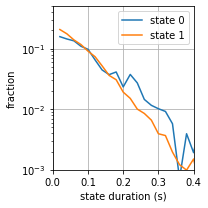

In [17]:
# Here we import tracks from a csv file where each row corresponds to a peak with a
# column for x position of the peak, a colum for y position, one for the frame of 
# the peak and another for the track ID of the peak, the columns do not have to be
# in a specific order but the column names (headers) need to be specified.

path = './tracks.csv'

# headers of the csv above are: X,Y,frame,track_ID,pred_0,pred_1,LocErrs0,LocErrs1.
# If the user have headers with other names, they can specify the header names in 
# the argument colnames which is a list with first element the x position, second
# element the x position, third element, the frame of the peak and fourth element
# the track ID of the peak.

dt = 0.02 # set time in between frames in second.

all_tracks, frames, opt_metrics = extrack.readers.read_table(path, # path of the file to read or list of paths.
                                      lengths = np.arange(5,50), # number of positions per track accepted (takes the first positions if a track is longer than the maximum value of lengths.
                                      dist_th = 0.3, # maximum distance allowed for consecutive positions. 
                                      frames_boundaries = [0, 10000], # minimum and maximum frames allowed.
                                      fmt = 'csv', # format of the document to be red, 'csv' or 'pkl', one can also just specify a separator e.g. ' '. 
                                      colnames = ['X', 'Y', 'frame', 'track_ID'], 
                                      opt_colnames = [], # list of additional metrics to collect e.g. ['QUALITY', 'TRACK_ID'].
                                      remove_no_disp = True)

params = extrack.tracking.generate_params(nb_states = 2,
                    LocErr_type = 1, # set to 1 to fit a unique localization error for all peaks.
                    nb_dims = 3, # only matters if LocErr_type == 2,
                    LocErr_bounds = [0.005, 0.1], # the initial guess on LocErr will be the geometric mean of the boundaries
                    D_max = 10, # maximal diffusion coefficient allowed
                    Fractions_bounds = [0.001, 0.99],
                    estimated_LocErr = None,
                    estimated_Ds = None, # D will be arbitrary spaced from 0 to D_max if None, otherwise input 1D array/list of Ds for each state from state 0 to nb_states - 1.
                    estimated_Fs = None, # fractions will be equal if None, otherwise input 1D array/list of fractions for each state from state 0 to nb_states - 1.
                    estimated_transition_rates = 0.1, # transition rate per step. [0.1,0.05,0.03,0.07,0.2,0.2]
                    slope_offsets_estimates = None # need to specify the list [slop, offset] if LocErr_type = 4.
                    )

# Parameter fitting:
model_fit = extrack.tracking.param_fitting(all_tracks = all_tracks,
                                          dt = dt,
                                          params = params,
                                          nb_states = 2,
                                          nb_substeps = 1,
                                          cell_dims = [1],
                                          frame_len = 4,
                                          verbose = 0,
                                          workers = 1, # increase the number of CPU workers for faster computing, do not work on windows or mac (keep to 1).
                                          steady_state = False,
                                          input_LocErr = None
                                          )

params = model_fit.params
for param in params:
    print(param, params[param].value)

# State annotation:
pred_Bs = extrack.tracking.predict_Bs(all_tracks,
                                      dt = dt,
                                      params = params,
                                      cell_dims=[1],
                                      nb_states=2,
                                      frame_len=8,
                                      workers = 1,
                                      input_LocErr = None)

# Position refinement
LocErr, ds, Fs, TrMat, pBL = extrack.tracking.extract_params(params, 
                                                             dt,
                                                             nb_states = 2,
                                                             nb_substeps = 1,
                                                             input_LocErr = None,
                                                             Matrix_type = 1)


LocErr = LocErr[0][0,0,0]
all_mus, all_refined_sigmas = extrack.refined_localization.position_refinement(all_tracks,
                                                                               LocErr,
                                                                               ds,
                                                                               Fs,
                                                                               TrMat,
                                                                               frame_len = 7)

refined_pos0 = {}
refined_pos1 = {}
refined_LocErrs = {}
for l in all_tracks.keys():
    refined_pos0[l] = all_mus[l][:,:,0]
    refined_pos1[l] = all_mus[l][:,:,1]
    refined_LocErrs[l] = all_refined_sigmas[l][:,:,0] # this corresponds to a shared sigma for x and y axes.

# Saving as csv file:
DATA = extrack.exporters.extrack_2_pandas(all_tracks,
                                          pred_Bs,
                                          frames = None,
                                          opt_metrics = {'refined_x_pos': refined_pos0,
                                                         'refined_y_pos': refined_pos1,
                                                         'refined_LocErrs': refined_LocErrs}
                                          )
print(DATA)

save_path = './saved_tracks2.csv'

DATA.to_csv(save_path)

# plotting state histograms:
extrack.visualization.visualize_states_durations(all_tracks,
                                                 params = params,
                                                 dt = dt,
                                                 cell_dims = [1],
                                                 nb_states = 2,
                                                 max_nb_states = 200,
                                                 long_tracks = False,
                                                 nb_steps_lim = 20,
                                                 steps = False)

#plt.legend(['estimated bound','estimated diff','true bound','true diff'])
